In [1]:
# coding: utf-8
from sklearn import __version__ as sklearn_version
from distutils.version import LooseVersion
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# *Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com)

# # Python Machine Learning - Code Examples

# # SVM Classifiers Using Scikit-Learn

In [3]:
if LooseVersion(sklearn_version) < LooseVersion('0.18'):
    raise ValueError('Please use scikit-learn 0.18 or newer')

In [4]:
# *The use of `watermark` is optional. You can install this IPython extension via "`pip install watermark`". For more information, please see: https://github.com/rasbt/watermark.*

# ### Overview

# - [Choosing a classification algorithm](#Choosing-a-classification-algorithm)
# - [First steps with scikit-learn](#First-steps-with-scikit-learn)
#     - [Training a perceptron via scikit-learn](#Training-a-perceptron-via-scikit-learn)
# - [Modeling class probabilities via logistic regression](#Modeling-class-probabilities-via-logistic-regression)
#     - [Logistic regression intuition and conditional probabilities](#Logistic-regression-intuition-and-conditional-probabilities)
#     - [Learning the weights of the logistic cost function](#Learning-the-weights-of-the-logistic-cost-function)
#     - [Training a logistic regression model with scikit-learn](#Training-a-logistic-regression-model-with-scikit-learn)
#     - [Tackling overfitting via regularization](#Tackling-overfitting-via-regularization)
# - [Maximum margin classification with support vector machines](#Maximum-margin-classification-with-support-vector-machines)
#     - [Maximum margin intuition](#Maximum-margin-intuition)
#     - [Dealing with the nonlinearly separable case using slack variables](#Dealing-with-the-nonlinearly-separable-case-using-slack-variables)
#     - [Alternative implementations in scikit-learn](#Alternative-implementations-in-scikit-learn)
# - [Solving nonlinear problems using a kernel SVM](#Solving-nonlinear-problems-using-a-kernel-SVM)
#     - [Using the kernel trick to find separating hyperplanes in higher dimensional space](#Using-the-kernel-trick-to-find-separating-hyperplanes-in-higher-dimensional-space)
# - [Decision tree learning](#Decision-tree-learning)
#     - [Maximizing information gain – getting the most bang for the buck](#Maximizing-information-gain-–-getting-the-most-bang-for-the-buck)
#     - [Building a decision tree](#Building-a-decision-tree)
#     - [Combining weak to strong learners via random forests](#Combining-weak-to-strong-learners-via-random-forests)
# - [K-nearest neighbors – a lazy learning algorithm](#K-nearest-neighbors-–-a-lazy-learning-algorithm)
# - [Summary](#Summary)

In [5]:
# # First steps with scikit-learn

# Loading the Iris dataset from scikit-learn. Here, the third column represents the petal length,
# and the fourth column the petal width of the flower samples. The classes are already converted to
# integer labels where 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica.


iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [6]:
# Splitting data into 70% training and 30% test data:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)


print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [7]:
# Standardizing the features:

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [8]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')


In [9]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [10]:
# # Maximum margin classification with support vector machines

# ## Maximum margin intuition

# ## Dealing with the nonlinearly separable case using slack variables

# In Scikit-Learn, C hyperparameter controls width of margin classification between two separating
# classes.
# A smaller C leads to wider street between the classes but more margin violations
# (but this will generalize better) and vice versa - a higher C leads to smaller margin width
# between the classes but lower margin violations, however this will not generalize well as it
# is overfitted.

In [11]:
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

SVC(kernel='linear', random_state=1)

c:\users\sumit dua\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


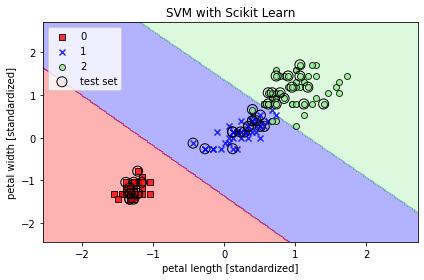

In [12]:
plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.title('SVM with Scikit Learn')
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_11.png', dpi=300)
plt.show()

In [13]:
# ## Alternative implementations in scikit-learn

#ppn = SGDClassifier(loss='perceptron', n_iter=1000)
#lr = SGDClassifier(loss='log', n_iter=1000)
#svm = SGDClassifier(loss='hinge', n_iter=1000)

# **Note**
# 
# - You can replace `Perceptron(n_iter, ...)` by `Perceptron(max_iter, ...)` in scikit-learn >= 0.19.
# The `n_iter` parameter is used here deriberately, because some people still use scikit-learn 0.18.

In [14]:
# Solving non-linear problems using a kernel SVM
# Create XOR data set

np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

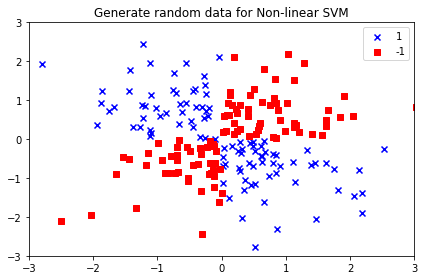

In [15]:
#plot the XOR data set

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')
plt.title('Generate random data for Non-linear SVM')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_12.png', dpi=300)
plt.show()

0.63


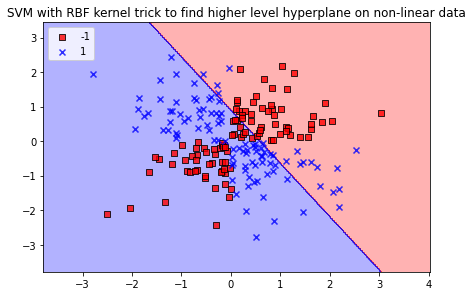

In [24]:
# Using the kernel trick to find separating hyperplanes in higher dimensional space

svm = SVC(kernel='linear', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
print(svm.score(X_xor, y_xor))
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
plt.title('SVM with RBF kernel trick to find higher level hyperplane on non-linear data')
#plt.savefig('images/03_14.png', dpi=300)
plt.show()

c:\users\sumit dua\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


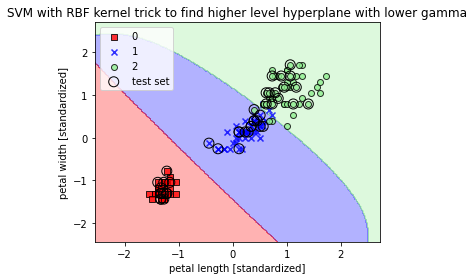

In [17]:
#Now lets see effect of varying gamma on IRIS Dataset classifier
#Note that gamma is Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’ kernels
#If we increase gamma, we get a tighter and bumpier decision boundary.
#As such, the gamma parameter also plays a role in controlling overfitting.

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.title('SVM with RBF kernel trick to find higher level hyperplane with lower gamma')
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_15.png', dpi=300)
plt.show()

In [18]:
#For lower gamma values, the classifier boundary is soft as shown above

c:\users\sumit dua\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


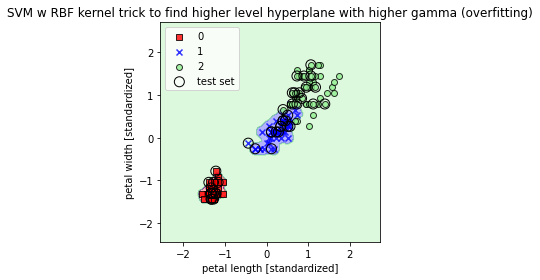

In [19]:
svm = SVC(kernel='rbf', random_state=1, gamma=100, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.title('SVM w RBF kernel trick to find higher level hyperplane with higher gamma (overfitting)')
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_16.png', dpi=300)
plt.show()

In [20]:
#For higher gamma values, the decision boundary becomes tighter as seen above.
#The above chart shows more overfitting around classes 0 and 1.

c:\users\sumit dua\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


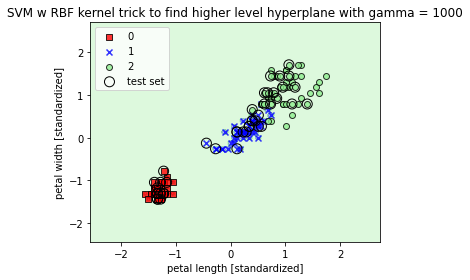

In [21]:
svm = SVC(kernel='rbf', random_state=1, gamma=1000, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.title('SVM w RBF kernel trick to find higher level hyperplane with gamma = 1000')
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_16.png', dpi=300)
plt.show()

In [25]:
#For even higher gamma values, the decision boundary becomes even more tighter as seen above.
#The above chart shows even more overfitting.


0.9523809523809523


c:\users\sumit dua\lib\site-packages\ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


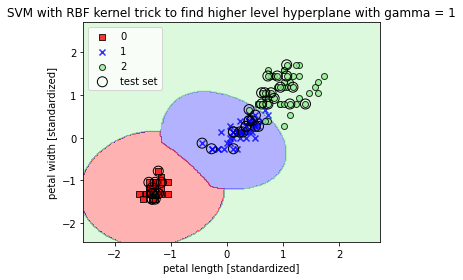

In [29]:
svm = SVC(kernel='rbf', random_state=1, gamma=1, C=1.0)
svm.fit(X_train_std, y_train)
print(svm.score(X_train_std, y_train))
plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.title('SVM with RBF kernel trick to find higher level hyperplane with gamma = 1')
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_15.png', dpi=300)
plt.show()